In [1]:
# import stuffs
%matplotlib inline
import numpy as np
import pandas as pd
from pyplotthemes import get_savefig, classictheme as plt
from lifelines.plotting import add_at_risk_counts
from lifelines.estimation import KaplanMeierFitter
from lifelines.estimation import median_survival_times
plt.latex = True
savefig = get_savefig('../fig', extensions=['pdf'])

# Load data
Columns will always be *target*, *event*, *inputs*

In [2]:
from datasets import get_colon, get_nwtco, get_flchain, get_pbc, get_lung

# Values of (trn, test)
datasets = {}

# Add the data sets
for name, getter in zip(["pbc", "lung", "colon", "nwtco", "flchain"],
                         [get_pbc, get_lung, get_colon, get_nwtco, get_flchain]):
    trn = getter(norm_in=True, norm_out=False, training=True)
    test = getter(norm_in=True, norm_out=False, training=False)
    datasets[name] = (trn, test)
    
    cens = (trn.iloc[:, 1] == 0)
    censcount = np.sum(cens) / trn.shape[0]
    print(name, "censed:", censcount)

pbc censed: 0.608163265306
lung censed: 0.27485380117
colon censed: 0.495689655172
nwtco censed: 0.857994041708
flchain censed: 0.724716245977


# Train our models

## Rpart
Because this dictates the group sizes used for the rest

In [3]:
from pysurvival.rpart import RPartModel

# Save values for later here
rpart_trn_preds = {}
rpart_test_preds =  {}
group_sizes = {}

# Default values in rpart actually
rpart_kwargs = dict(highlim=0.1,
                    lowlim=0.1,
                    minsplit=20,
                    minbucket=None,
                    xval=3,
                    cp=0.01)

def show_rpart(trn, rm=None, joinmid=False):
    '''
    By default, the implementation will join non-significantly different
    groups into low and high groups.
    
    Returns an rpart model
    '''
    if rm is None:
        # Low limits so we don't merge significantly different groups yet
        rm = RPartModel(**rpart_kwargs)
        rm.fit(trn, trn.columns[0], trn.columns[1])
    
    preds = rm.predict(trn)
    up = np.unique(preds)
    plt.figure()
    fitters = []
    mygroup = np.zeros_like(preds, dtype=bool)
    for i, g in enumerate(sorted(up)):
        members = (preds == g).ravel()
        mygroup += members
        if i == len(up) - 1:
            pass
        elif g in rm._high and up[i+1] in rm._high:
            # Both in high
            continue
        elif g in rm._low and up[i+1] in rm._low:
            # Both in low
            continue
        elif (joinmid and 
              (g not in rm._high and up[i+1] not in rm._high) and
              (g not in rm._low and up[i+1] not in rm._low)):
            # Both in mid
            continue
        print("Group {} has size {} = {:.2f}".format(i,
                                                     np.sum(mygroup), 
                                                     np.sum(mygroup)/trn.shape[0]))
        kmf = KaplanMeierFitter()
        fitters.append(kmf)
        
        kmf.fit(trn.iloc[mygroup, 0],
                trn.iloc[mygroup, 1],
                label="{}".format(i))
        res = kmf.plot(ax=plt.gca(), ci_show=False)
    
        # Reset my group
        mygroup = np.zeros_like(preds, dtype=bool)
        
    # Nicer legend
    plt.legend(loc='best', framealpha=0.0, ncol=1 if joinmid else 3)

    plt.ylim((0, 1.05))
    add_at_risk_counts(*fitters)
    
    return rm

Group 4 has size 88 = 0.36
Group 5 has size 27 = 0.11
Group 6 has size 15 = 0.06
Group 7 has size 7 = 0.03
Group 8 has size 13 = 0.05
Group 9 has size 8 = 0.03
Group 10 has size 17 = 0.07
Group 11 has size 13 = 0.05
Group 15 has size 57 = 0.23
Group 4 has size 88 = 0.36
Group 11 has size 100 = 0.41
Group 15 has size 57 = 0.23


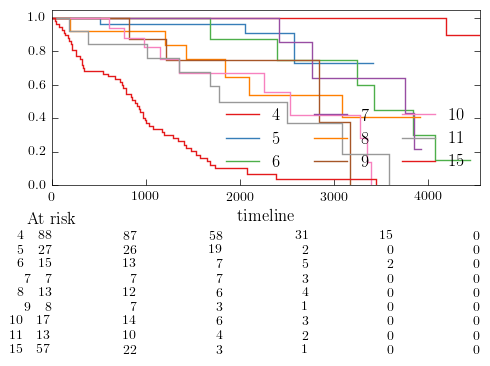

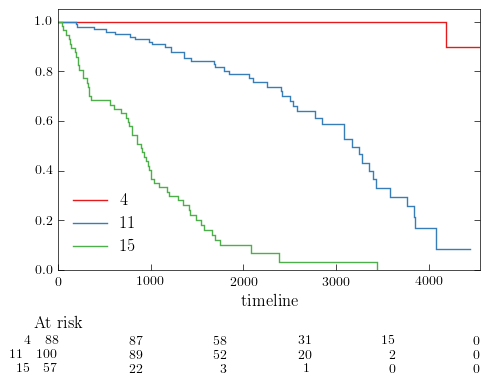

In [4]:
name = 'pbc'
trn, test = datasets[name]
rm = show_rpart(trn)
# PBC finds reasonable groups without merging non-significant groups
up = np.unique(rm.predict(trn))
#rm._high.append(up[-2])
#print("High risk groups:", rm._high)
show_rpart(trn, rm, joinmid=True)

preds = rm.predict_classes(trn)
rpart_trn_preds[name] = preds
rpart_test_preds[name] = rm.predict_classes(test)

group_sizes[name] = (int(np.sum(preds == 'high')), 
                     int(np.sum(preds == 'low')))

Group 1 has size 22 = 0.13
Group 2 has size 17 = 0.10
Group 3 has size 9 = 0.05
Group 4 has size 19 = 0.11
Group 5 has size 7 = 0.04
Group 6 has size 17 = 0.10
Group 12 has size 80 = 0.47
Low risk groups: [0.27534547670833437, 0.27693381720928589, 0.58081827076604597]
Group 2 has size 39 = 0.23
Group 6 has size 52 = 0.30
Group 12 has size 80 = 0.47


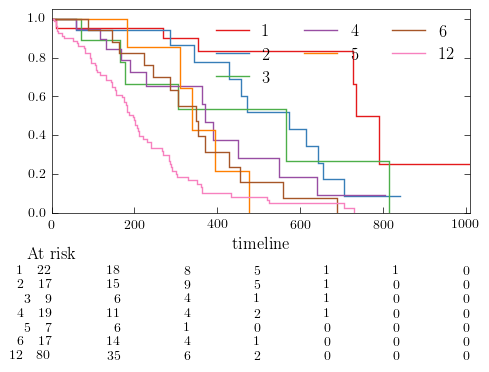

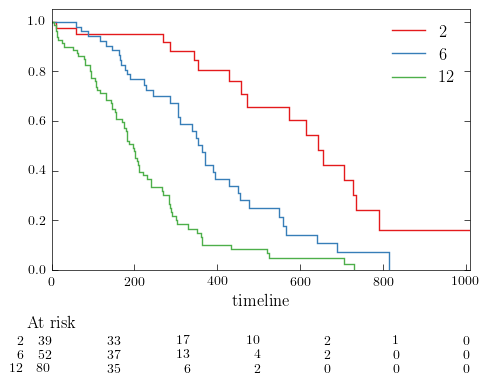

In [5]:
name = 'lung'
trn, test = datasets[name]
rm = show_rpart(trn)
# LUNG needs merging low risk groups
up = np.unique(rm.predict(trn))
rm._low.append(up[2])
print("Low risk groups:", rm._low)

show_rpart(trn, rm, joinmid=True)

preds = rm.predict_classes(trn)
rpart_trn_preds[name] = preds
rpart_test_preds[name] = rm.predict_classes(test)

group_sizes[name] = (int(np.sum(preds == 'high')), 
                     int(np.sum(preds == 'low')))

Group 0 has size 71 = 0.10
Group 1 has size 145 = 0.21
Group 2 has size 272 = 0.39
Group 5 has size 208 = 0.30
Low risk groups: [0.24616618934561699, 0.5374116150971846]
High risk groups: [3.0948674006959433, 1.6460031120776577, 1.5754895904741031]
Group 1 has size 216 = 0.31
Group 2 has size 272 = 0.39
Group 5 has size 208 = 0.30


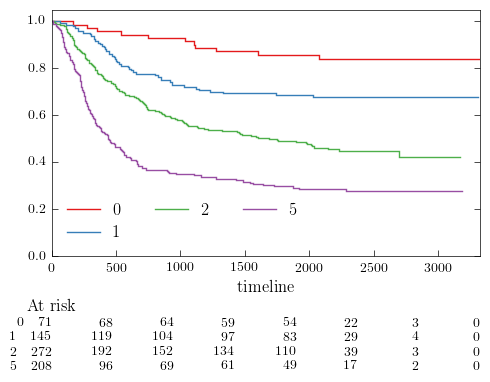

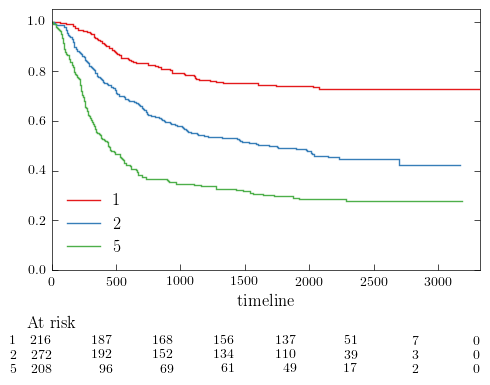

In [6]:
name = 'colon'
trn, test = datasets[name]
rm = show_rpart(trn)
# COLON requires merging 
up = np.unique(rm.predict(trn))
rm._low.append(up[1])
print("Low risk groups:", rm._low)
#rm._high.append(up[-3])
print("High risk groups:", rm._high)
show_rpart(trn, rm, joinmid=True)

preds = rm.predict_classes(trn)
rpart_trn_preds[name] = preds
rpart_test_preds[name] = rm.predict_classes(test)

group_sizes[name] = (int(np.sum(preds == 'high')), 
                     int(np.sum(preds == 'low')))

Group 0 has size 3272 = 0.55
Group 1 has size 1438 = 0.24
Group 3 has size 1193 = 0.20
Low risk groups: [0.33686666778107871]
High risk groups: [8.1056320388011542, 3.009865289679559]
Group 0 has size 3272 = 0.55
Group 1 has size 1438 = 0.24
Group 3 has size 1193 = 0.20


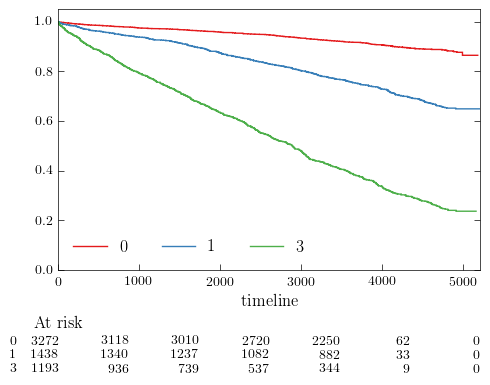

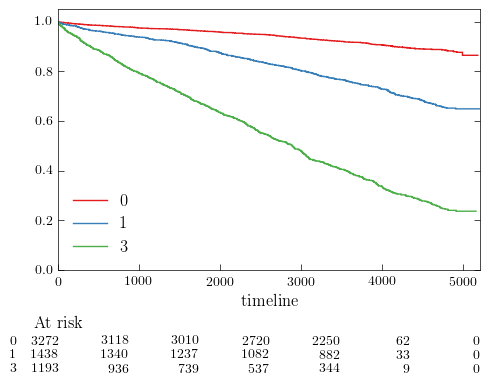

In [7]:
name = 'flchain'
trn, test = datasets[name]
rm = show_rpart(trn)
# FLCHAIN gives 3 significantly different groups, where the
# high risk group is very large (>.5) and the low risk group is small (0.2)
# and the mid groups is (0.24). In this case, one should leave the groups be.

up = np.unique(rm.predict(trn))
#rm._low.append(up[1])
print("Low risk groups:", rm._low)
#rm._high.append(up[-2])
print("High risk groups:", rm._high)
show_rpart(trn, rm, joinmid=True)

preds = rm.predict_classes(trn)
rpart_trn_preds[name] = preds
rpart_test_preds[name] = rm.predict_classes(test)

group_sizes[name] = (int(np.sum(preds == 'high')), 
                     int(np.sum(preds == 'low')))

Group 0 has size 1232 = 0.41
Group 1 has size 1183 = 0.39
Group 2 has size 96 = 0.03
Group 5 has size 510 = 0.17
High risk groups: [13.893294227665161, 3.9996498800207285, 1.8747162224287353]
Group 0 has size 1232 = 0.41
Group 2 has size 1279 = 0.42
Group 5 has size 510 = 0.17


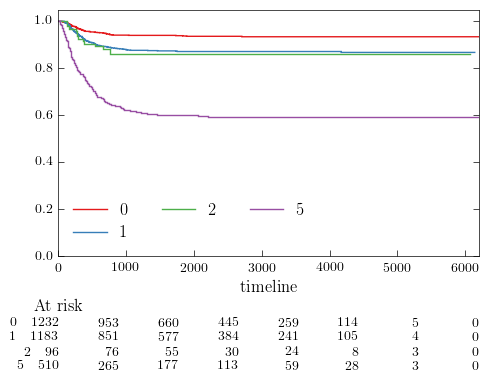

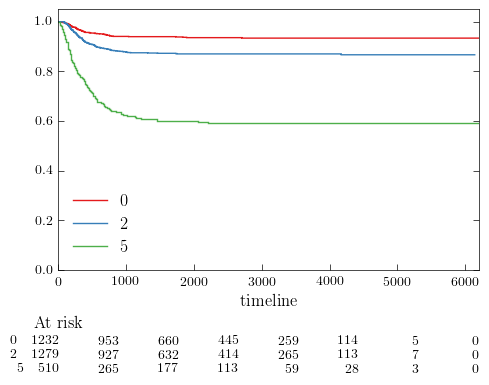

In [8]:
name = 'nwtco'
trn, test = datasets[name]
rm = show_rpart(trn)
# NWTC gives 4 significantly different groups (join two mid groups
# which are overlapped). The low risk group is large (0.41) and the
# two high risk groups (quite separated) joined together make up (0.17) and
# here I'd say the data set does not warrant further action.
up = np.unique(rm.predict(trn))
#print(up)
#rm._high.append(up[-3])
print("High risk groups:", rm._high)
show_rpart(trn, rm, joinmid=True)

preds = rm.predict_classes(trn)
rpart_trn_preds[name] = preds
rpart_test_preds[name] = rm.predict_classes(test)

group_sizes[name] = (int(np.sum(preds == 'high')), 
                     int(np.sum(preds == 'low')))

## Cox
Doing quartiles

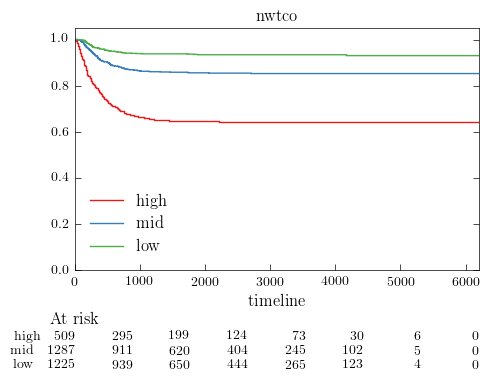

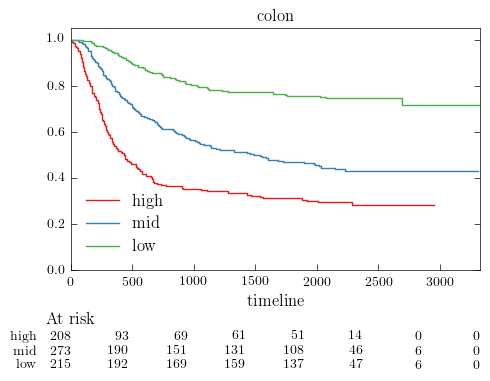

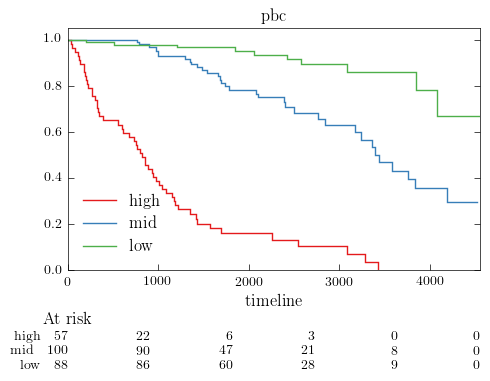

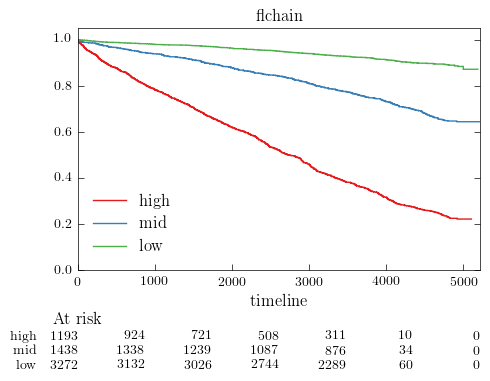

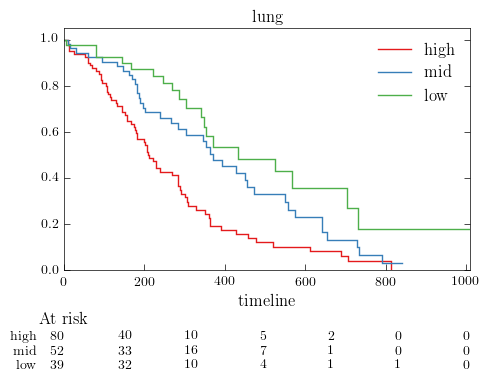

In [9]:
from classcox import CoxClasser


# Save predictions for later
cox_trn_preds = {}
cox_test_preds = {}

for name, (trn, test) in datasets.items():
    total = trn.shape[0]
    # Get the rpart sizes for this data
    high_size, low_size = group_sizes[name]
    cox = CoxClasser(100 * (1 - high_size / total),
                     100 * low_size / total)
    
    #cox = CoxClasser()
    
    cox.fit(trn, trn.columns[0], trn.columns[1])
    
    cox_test_preds[name] = cox.predict_classes(test)
    
    preds = cox.predict_classes(trn)
    cox_trn_preds[name] = preds
    
    plt.figure()
    fitters = []
    for g in ['high', 'mid', 'low']:
        members = (preds == g).values.ravel()
        if not np.any(members):
            continue
            
        kmf = KaplanMeierFitter()
        fitters.append(kmf)
        
        kmf.fit(trn.iloc[members, 0],
                trn.iloc[members, 1],
                label="{}".format(g))
        res = kmf.plot(ax=plt.gca(), ci_show=False)
    
    plt.legend(loc='best', framealpha=0)

    plt.ylim((0, 1.05))
    plt.title(name)
    add_at_risk_counts(*fitters)

## ANN
Again with group size from rpart

nwtco
colon
pbc
flchain
lung


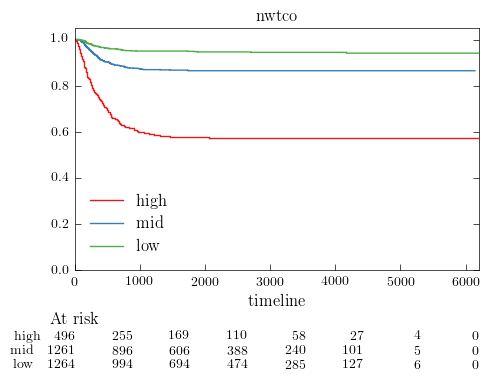

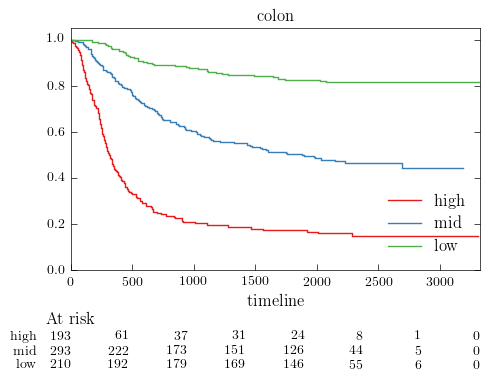

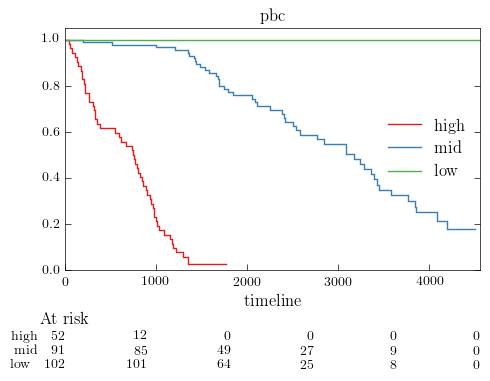

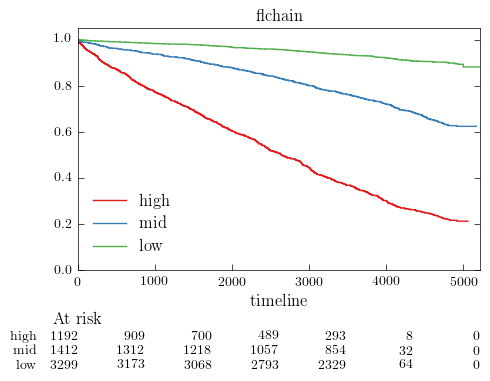

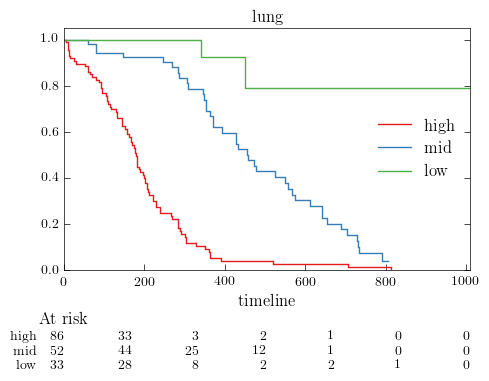

In [10]:
import ann
from classensemble import ClassEnsemble
from helpers import get_net


# Save predictions for later
ann_trn_preds = {}
ann_test_preds = {}

for name, (trn, test) in datasets.items():
    print(name)
    total = trn.shape[0]
    # Get the rpart sizes for this data
    high_size, low_size = group_sizes[name]
    
    incols = trn.shape[1] - 2
    hnets = []
    lnets = []
    
    netcount = 34
    for i in range(netcount):
        if i % 2:
            n = get_net(incols, high_size, ann.geneticnetwork.FITNESS_SURV_KAPLAN_MIN)
            hnets.append(n)
        else:
            n = get_net(incols, low_size, ann.geneticnetwork.FITNESS_SURV_KAPLAN_MAX)
            lnets.append(n)
            
    e = ClassEnsemble(hnets, lnets)
    
    e.fit(trn, trn.columns[0], trn.columns[1])
    
    ann_test_preds[name] = e.predict_classes(test)
    
    preds = e.predict_classes(trn)
    ann_trn_preds[name] = preds
    
    plt.figure()
    fitters = []
    for g in ['high', 'mid', 'low']:
        members = (preds == g).values.ravel()
        if not np.any(members):
            continue
            
        kmf = KaplanMeierFitter()
        fitters.append(kmf)
        
        kmf.fit(trn.iloc[members, 0],
                trn.iloc[members, 1],
                label="{}".format(g))
        res = kmf.plot(ax=plt.gca(), ci_show=False)
    
    plt.legend(loc='best', framealpha=0)

    plt.ylim((0, 1.05))
    plt.title(name)
    add_at_risk_counts(*fitters)

In [11]:
from pickle import dump
import os

# These are expensive, so save to disk
path = "ann_test_predictions.pickle"
if os.path.exists(path):
    raise ValueError("File exists. Should not be overwritten")

with open(path, 'wb') as F:
    dump(ann_test_preds, F)
    
path = "ann_trn_predictions.pickle"
if os.path.exists(path):
    raise ValueError("File exists. Should not be overwritten")

with open(path, 'wb') as F:
    dump(ann_trn_preds, F)

In [12]:
from pickle import load
import os

# Read them back
path = "ann_test_predictions.pickle"
with open(path, 'rb') as F:
    ann_test_preds = load(F)
    
# Read them back
path = "ann_trn_predictions.pickle"
with open(path, 'rb') as F:
    ann_trn_preds = load(F)

# Results

ERROR! Session/line number was not unique in database. History logging moved to new session 16


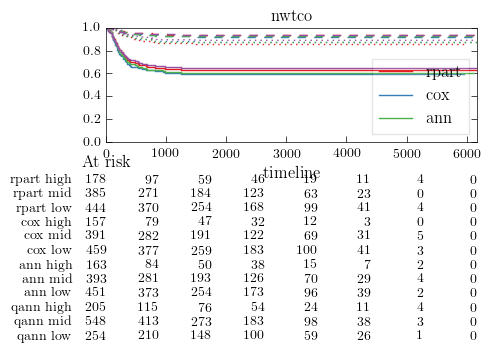

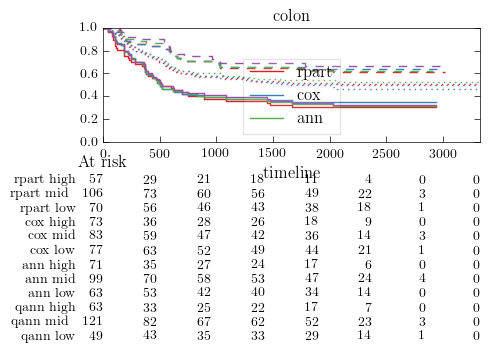

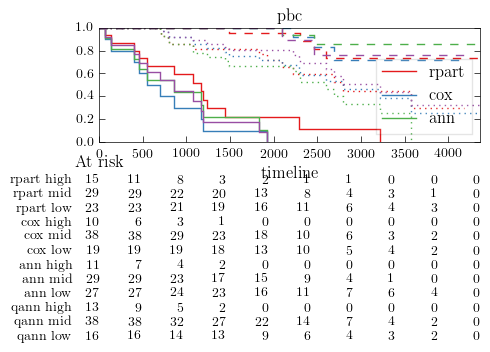

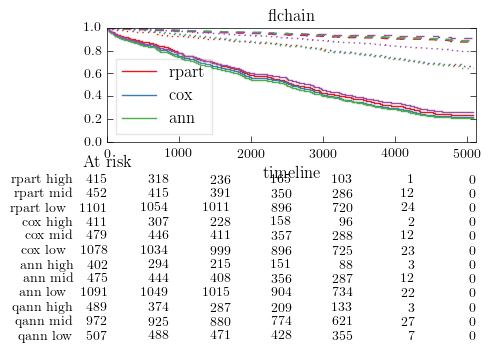

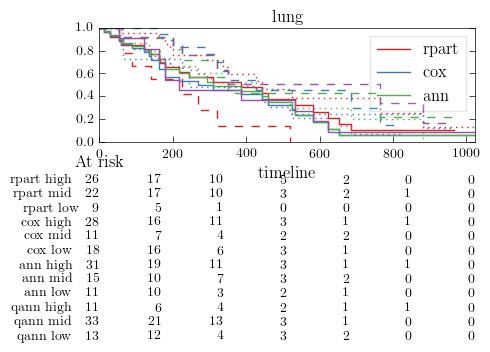

In [18]:
model_names = ('rpart', 'cox', 'ann')

for name, (trn, test) in datasets.items():
    plt.figure()
    plt.title(name)

    fitters = []
    for color, (model, grouplabels) in enumerate(zip(model_names,
                                  [rpart_test_preds[name],
                                   cox_test_preds[name],
                                   ann_test_preds[name]])):
        for g in ['high', 'mid', 'low']:
            members = (grouplabels == g).values.ravel()
        
            if not np.any(members):
                continue
                
            if g == 'mid':
                linestyle = ':'
            elif g == 'low':
                linestyle = '--'
            else:
                linestyle = '-'
            
            kmf = KaplanMeierFitter()
            fitters.append(kmf)
        
            kmf.fit(test.iloc[members, 0],
                    test.iloc[members, 1],
                    label="{} {}".format(model, g))
            res = kmf.plot(ax=plt.gca(), color=plt.colors[color], 
                           ci_show=False, linestyle=linestyle)

    # Override legend entries
    leg = plt.legend(loc='best', framealpha=0.1).get_lines()
    plt.legend([leg[0], leg[3], leg[6]], model_names,
                loc='best', framealpha=0.1)

    plt.ylim((0, 1))
    add_at_risk_counts(*fitters)
    
    savefig("test" + name)